In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import os
import pickle
import time


# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
def create_mnist_dataloaders(batch_size=64, val_split=0.1, num_workers=2):
    """
    Create train, validation and test dataloaders for MNIST dataset.

    Args:
        batch_size (int): Batch size for the dataloaders
        val_split (float): Fraction of training data to use for validation
        num_workers (int): Number of workers for data loading

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Define transforms for the data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Download and load the training data
    full_train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Split training data into train and validation sets
    val_size = int(len(full_train_dataset) * val_split)
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size]
    )

    # Download and load the test data
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

# Create the global data loaders to be reused
train_loader, val_loader, test_loader = create_mnist_dataloaders()

Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000


In [3]:
model_results = {}

def count_parameters(model):
    """
    Count the number of trainable parameters in a model.

    Args:
        model: PyTorch model

    Returns:
        int: Number of trainable parameters
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(model, data_loader, device):
    """
    Calculate accuracy of the model on the given data.

    Args:
        model: PyTorch model
        data_loader: DataLoader containing the data
        device: Device to run the model on

    Returns:
        float: Accuracy as a percentage
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train_and_evaluate_model(model_class, model_name, hidden_size=128, epochs=10,
                            learning_rate=0.001, export_dir='./models'):
    """
    Train, evaluate, and store model information.

    Args:
        model_class: PyTorch model class
        model_name: Name for the model
        hidden_size: Size of hidden layers
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        export_dir: Directory to save exported models

    Returns:
        dict: Dictionary with model information and results
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = model_class(hidden_size=hidden_size).to(device)
    print(f"\nTraining {model_name}...")

    # Count parameters
    param_count = count_parameters(model)
    print(f"Number of trainable parameters: {param_count:,}")

    # Set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For storing metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Create a single progress bar for the entire training process
    pbar = tqdm(total=epochs, desc=f"Training {model_name}")

    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch metrics for training
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate epoch metrics for validation
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update progress bar with current metrics
        pbar.update(1)
        pbar.set_postfix({
            'epoch': f"{epoch+1}/{epochs}",
            'train_loss': f"{epoch_train_loss:.4f}",
            'train_acc': f"{epoch_train_acc:.2f}%",
            'val_loss': f"{epoch_val_loss:.4f}",
            'val_acc': f"{epoch_val_acc:.2f}%"
        })

    # Close progress bar
    pbar.close()

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Plot training and validation metrics
    plot_training_metrics(train_losses, val_losses, train_accs, val_accs, model_name)

    # Export model and calculate size
    os.makedirs(export_dir, exist_ok=True)
    model_path = os.path.join(export_dir, f"{model_name}.pt")

    # Save the model
    torch.save(model.state_dict(), model_path)

    # Get model file size
    model_size_bytes = os.path.getsize(model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")

    # Evaluate on test set
    test_acc = calculate_accuracy(model, test_loader, device)
    print(f"Test accuracy: {test_acc:.2f}%")

    # Store results
    results = {
        'model_name': model_name,
        'parameters': param_count,
        'training_time': training_time,
        'model_size_mb': model_size_mb,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'test_acc': test_acc,
        'hidden_size': hidden_size,
        'epochs': epochs,
        'learning_rate': learning_rate
    }

    # Add to global dictionary
    model_results[model_name] = results

    # Save results to pickle file
    with open('model_results.pkl', 'wb') as f:
        pickle.dump(model_results, f)

    return results

def plot_training_metrics(train_losses, val_losses, train_accs, val_accs, model_name):
    """
    Plot training and validation metrics over epochs.

    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
        model_name: Name of the model for the plot title
    """
    sns.set(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(10, 6))

    epochs = range(1, len(train_losses) + 1)

    # Plot losses on left y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, 'o-', color='tab:red', label='Training Loss')
    ax1.plot(epochs, val_losses, 'o-', color='tab:orange', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')
    ax2.plot(epochs, train_accs, 'o-', color='tab:blue', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'o-', color='tab:cyan', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title(f'Training and Validation Metrics - {model_name}')
    plt.tight_layout()
    plt.savefig(f"{model_name}_training_plot.png")
    plt.show()

Using device: cuda

Training SimpleNet...
Number of trainable parameters: 203,530


Training SimpleNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 131.10 seconds


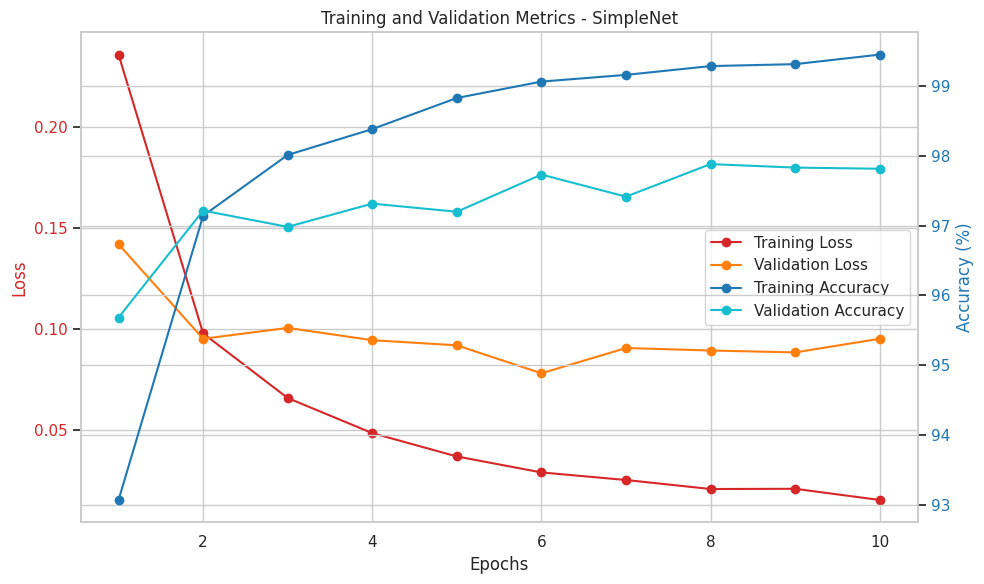

Model size: 0.78 MB
Test accuracy: 97.65%
Using device: cuda

Training MediumNet...
Number of trainable parameters: 335,114


Training MediumNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 144.84 seconds


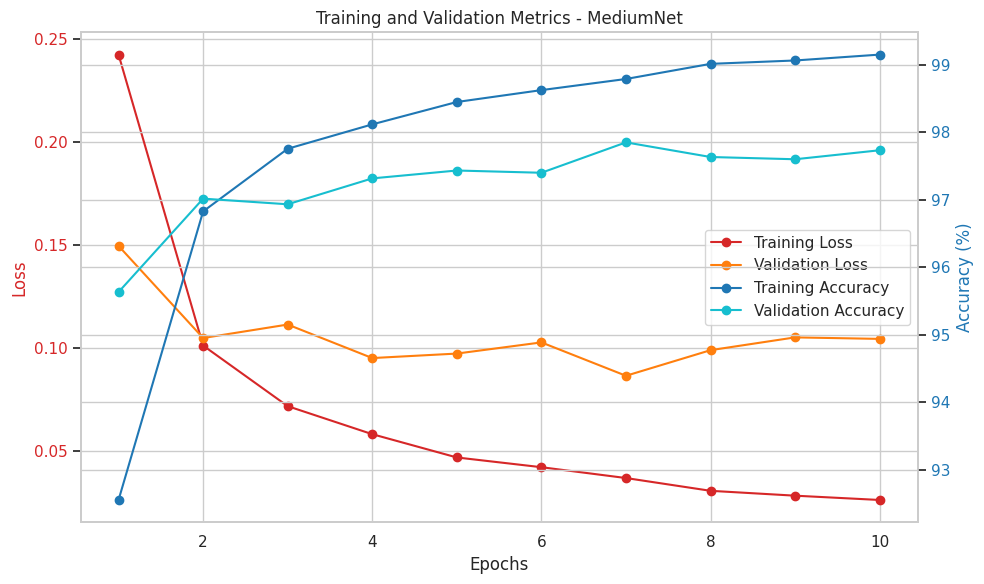

Model size: 1.28 MB
Test accuracy: 97.60%
Using device: cuda

Training DeepNet...
Number of trainable parameters: 466,698


Training DeepNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 138.09 seconds


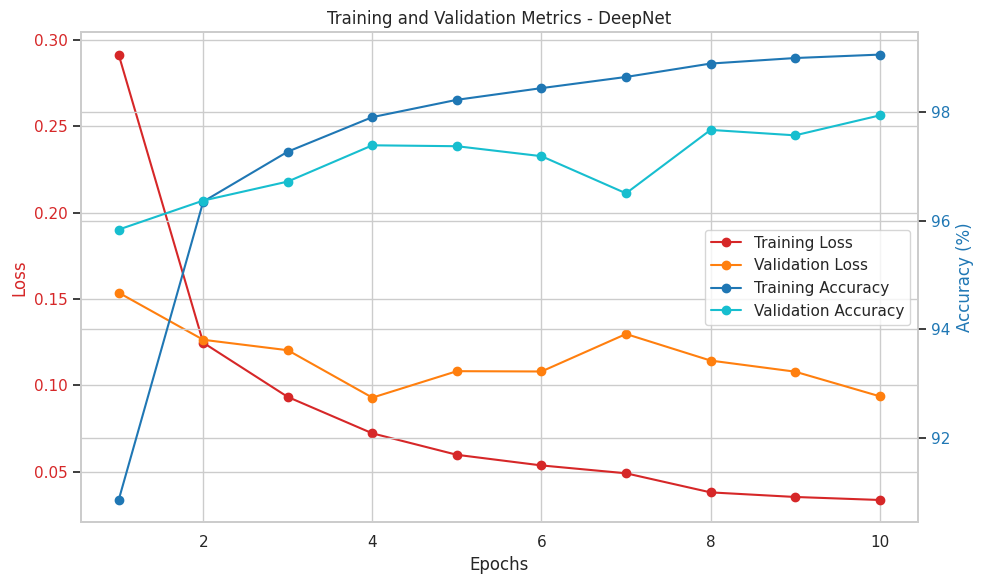

Model size: 1.78 MB
Test accuracy: 97.90%


In [4]:
# Define model classes with increasing depth
class SimpleNet(nn.Module):
    """Single hidden layer neural network for MNIST."""
    def __init__(self, hidden_size=128):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class MediumNet(nn.Module):
    """Three hidden layer neural network for MNIST."""
    def __init__(self, hidden_size=128):
        super(MediumNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

class DeepNet(nn.Module):
    """Five hidden layer neural network for MNIST."""
    def __init__(self, hidden_size=128):
        super(DeepNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        return x


_ = train_and_evaluate_model(SimpleNet, "SimpleNet", hidden_size=256)
_ = train_and_evaluate_model(MediumNet, "MediumNet", hidden_size=256)
_ = train_and_evaluate_model(DeepNet, "DeepNet", hidden_size=256)

Using device: cuda

Training SimpleCNN...
Number of trainable parameters: 31,530


Training SimpleCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 123.56 seconds


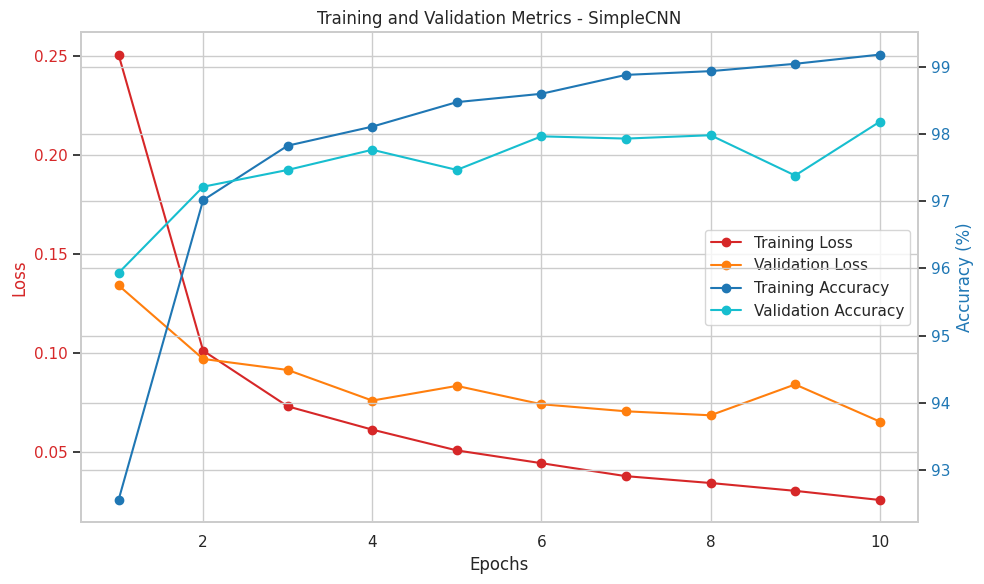

Model size: 0.12 MB
Test accuracy: 97.97%
Using device: cuda

Training MediumCNN...
Number of trainable parameters: 54,666


Training MediumCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 134.13 seconds


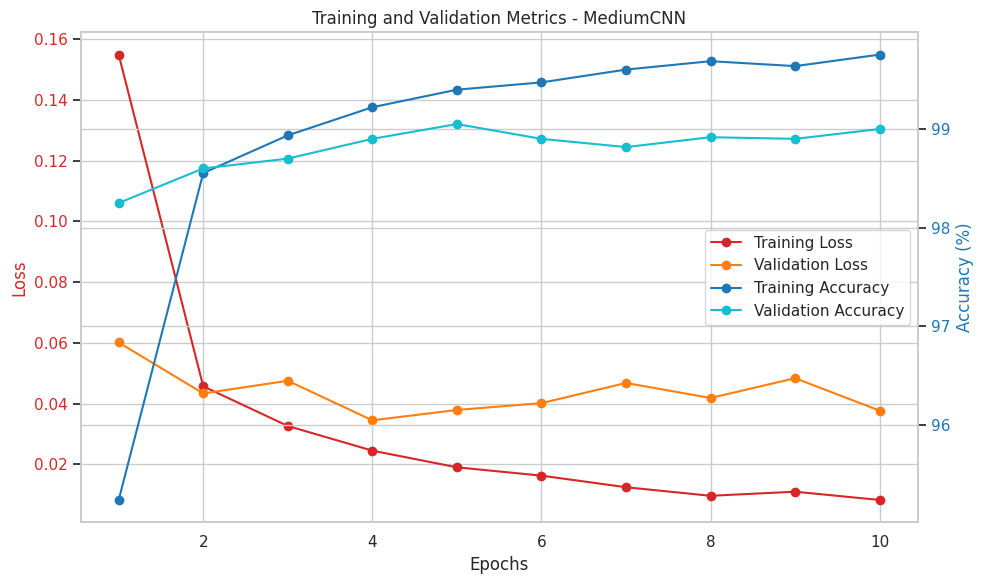

Model size: 0.21 MB
Test accuracy: 99.18%
Using device: cuda

Training DeepCNN...
Number of trainable parameters: 938,922


Training DeepCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 152.73 seconds


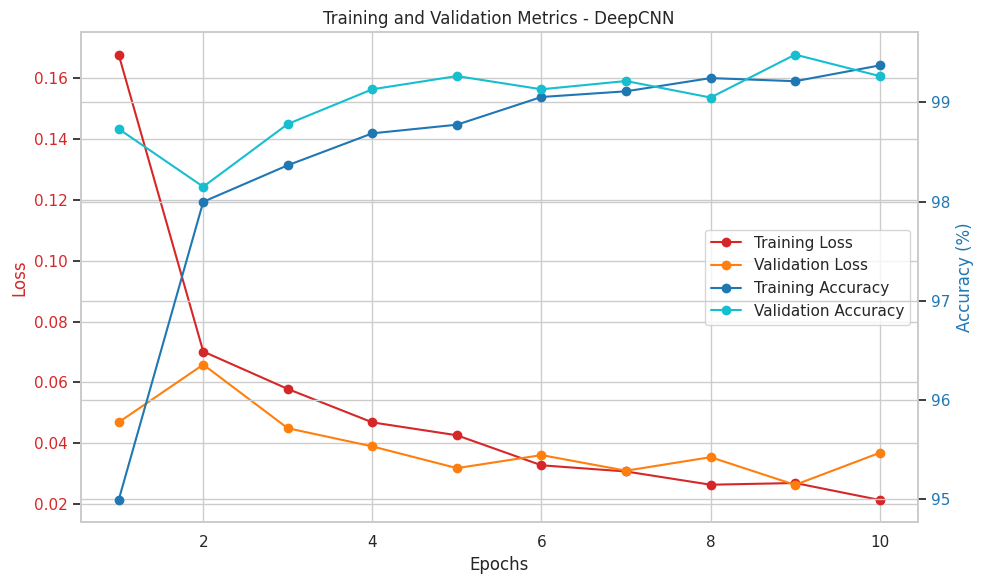

Model size: 3.60 MB
Test accuracy: 99.42%


In [6]:
# Define Convolutional Neural Network classes with increasing depth
class SimpleCNN(nn.Module):
    """Single convolutional layer CNN for MNIST."""
    def __init__(self, hidden_size=64):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)          # [batch, hidden_size, 28, 28]
        x = self.relu(x)
        x = self.pool(x)           # [batch, hidden_size, 14, 14]
        x = self.flatten(x)        # [batch, hidden_size * 14 * 14]
        x = self.fc(x)             # [batch, 10]
        return x

class MediumCNN(nn.Module):
    """Three convolutional layers CNN for MNIST."""
    def __init__(self, hidden_size=64):
        super(MediumCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size*4 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)          # [batch, hidden_size, 28, 28]
        x = self.relu1(x)
        x = self.pool1(x)          # [batch, hidden_size, 14, 14]

        x = self.conv2(x)          # [batch, hidden_size*2, 14, 14]
        x = self.relu2(x)
        x = self.pool2(x)          # [batch, hidden_size*2, 7, 7]

        x = self.conv3(x)          # [batch, hidden_size*4, 7, 7]
        x = self.relu3(x)

        x = self.flatten(x)        # [batch, hidden_size*4 * 7 * 7]
        x = self.fc(x)             # [batch, 10]
        return x

class DeepCNN(nn.Module):
    """Five convolutional layers CNN for MNIST."""
    def __init__(self, hidden_size=32):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_size*2)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_size*4)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(hidden_size*4, hidden_size*4, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_size*4)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(hidden_size*4, hidden_size*8, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_size*8)
        self.relu5 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size*8 * 7 * 7, 128)
        self.relu6 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)          # [batch, hidden_size, 28, 28]
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)          # [batch, hidden_size*2, 28, 28]
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)          # [batch, hidden_size*2, 14, 14]

        x = self.conv3(x)          # [batch, hidden_size*4, 14, 14]
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)          # [batch, hidden_size*4, 14, 14]
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)          # [batch, hidden_size*4, 7, 7]

        x = self.conv5(x)          # [batch, hidden_size*8, 7, 7]
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.flatten(x)        # [batch, hidden_size*8 * 7 * 7]
        x = self.fc1(x)            # [batch, 128]
        x = self.relu6(x)
        x = self.dropout(x)
        x = self.fc2(x)            # [batch, 10]
        return x

_ = train_and_evaluate_model(SimpleCNN, "SimpleCNN", hidden_size=16)
_ = train_and_evaluate_model(MediumCNN, "MediumCNN", hidden_size=16)
_ = train_and_evaluate_model(DeepCNN, "DeepCNN", hidden_size=16)

Using device: cuda

Training SimpleResNet...
Number of trainable parameters: 9,690


Training SimpleResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 149.12 seconds


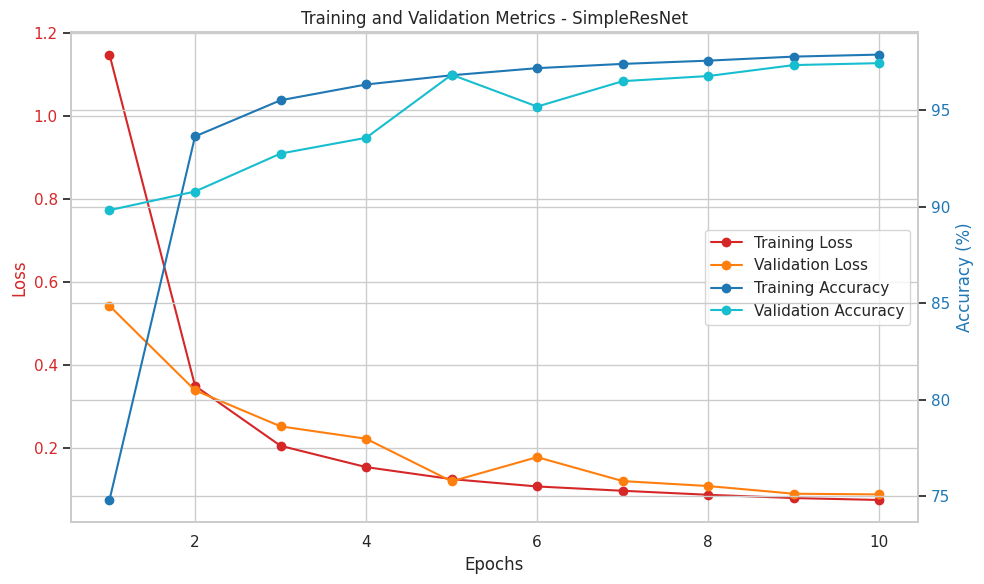

Model size: 0.05 MB
Test accuracy: 97.47%
Using device: cuda

Training MediumResNet...
Number of trainable parameters: 42,938


Training MediumResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 166.69 seconds


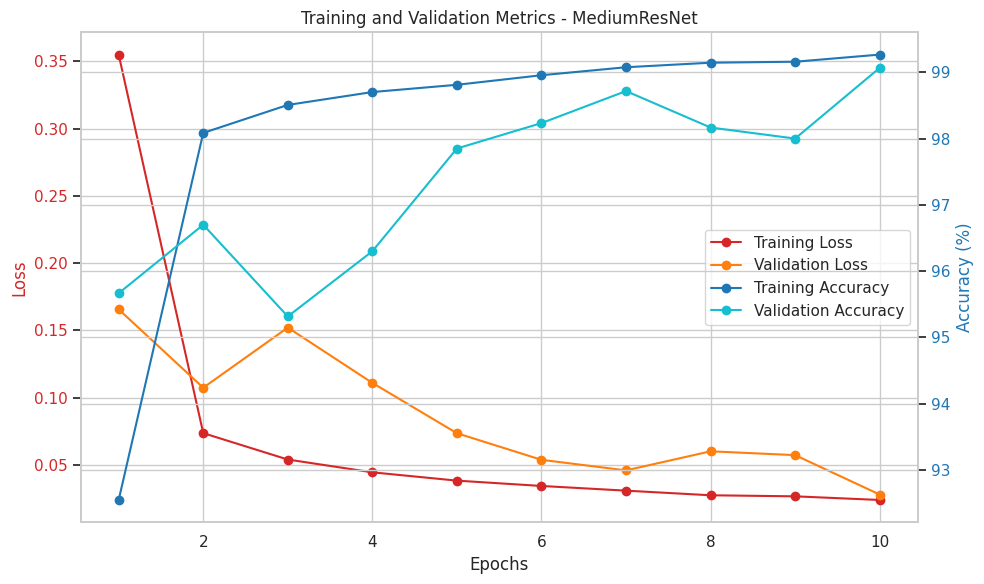

Model size: 0.19 MB
Test accuracy: 99.25%
Using device: cuda

Training DeepResNet...
Number of trainable parameters: 267,514


Training DeepResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 203.22 seconds


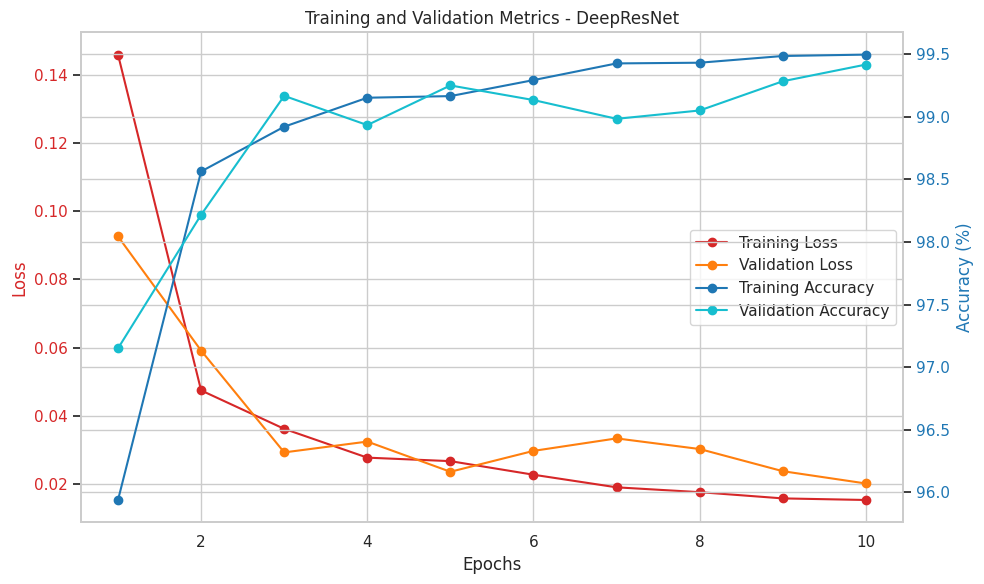

Model size: 1.06 MB
Test accuracy: 99.39%


In [13]:
# Define Residual Block
class ResidualBlock(nn.Module):
    """Basic Residual Block."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Simple ResNet with 2 Residual Blocks
class SimpleResNet(nn.Module):
    """ResNet with 2 residual blocks."""
    def __init__(self, hidden_size=16):
        super(SimpleResNet, self).__init__()
        self.in_channels = hidden_size

        # Initial convolution
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(hidden_size, 2, stride=1)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_size, 10)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# Medium ResNet with 2 groups of Residual Blocks
class MediumResNet(nn.Module):
    """ResNet with 2 groups of residual blocks (4 blocks total)."""
    def __init__(self, hidden_size=16):
        super(MediumResNet, self).__init__()
        self.in_channels = hidden_size

        # Initial convolution
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(hidden_size, 2, stride=1)
        self.layer2 = self._make_layer(hidden_size*2, 2, stride=2)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_size*2, 10)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# Deep ResNet with 3 groups of Residual Blocks
class DeepResNet(nn.Module):
    """ResNet with 3 groups of residual blocks (8 blocks total)."""
    def __init__(self, hidden_size=16):
        super(DeepResNet, self).__init__()
        self.in_channels = hidden_size

        # Initial convolution
        self.conv1 = nn.Conv2d(1, hidden_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(hidden_size, 2, stride=1)
        self.layer2 = self._make_layer(hidden_size*2, 3, stride=2)
        self.layer3 = self._make_layer(hidden_size*4, 3, stride=2)

        # Global average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_size*4, 10)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# Train the ResNet models
_ = train_and_evaluate_model(SimpleResNet, "SimpleResNet", hidden_size=16)
_ = train_and_evaluate_model(MediumResNet, "MediumResNet", hidden_size=16)
_ = train_and_evaluate_model(DeepResNet, "DeepResNet", hidden_size=16)

Using device for training: cuda

Training SimpleNet...
Number of trainable parameters: 203,530


Training SimpleNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 146.20 seconds


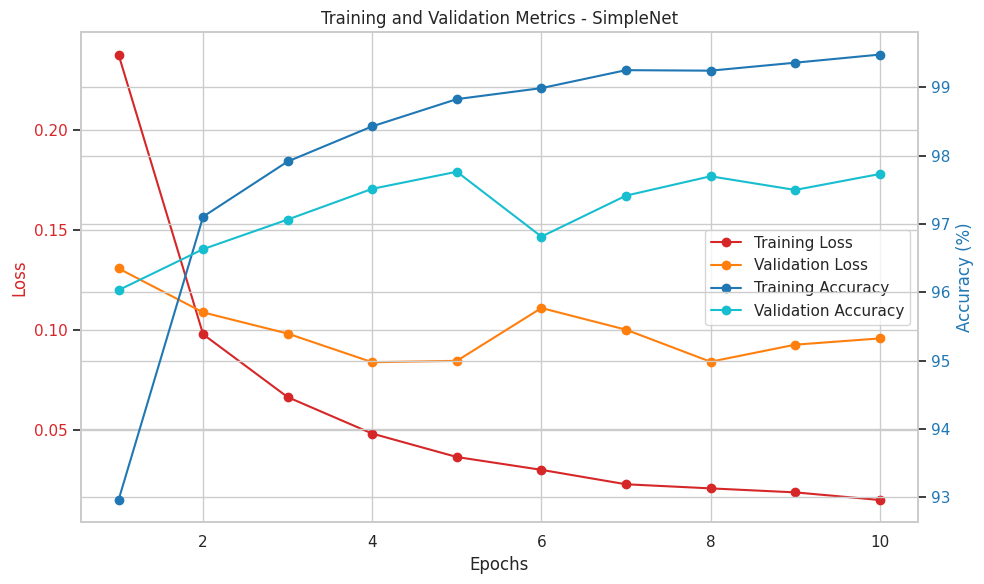

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 97.87%
Applying dynamic quantization to SimpleNet...
Quantization completed in 0.01 seconds
Quantized model size: 0.20 MB
Original model size: 0.78 MB
Size reduction: 74.53%
Evaluating quantized model on CPU...
Quantized model test accuracy: 97.86%
Accuracy change: -0.01%
Using device for training: cuda

Training MediumNet...
Number of trainable parameters: 335,114


Training MediumNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 147.76 seconds


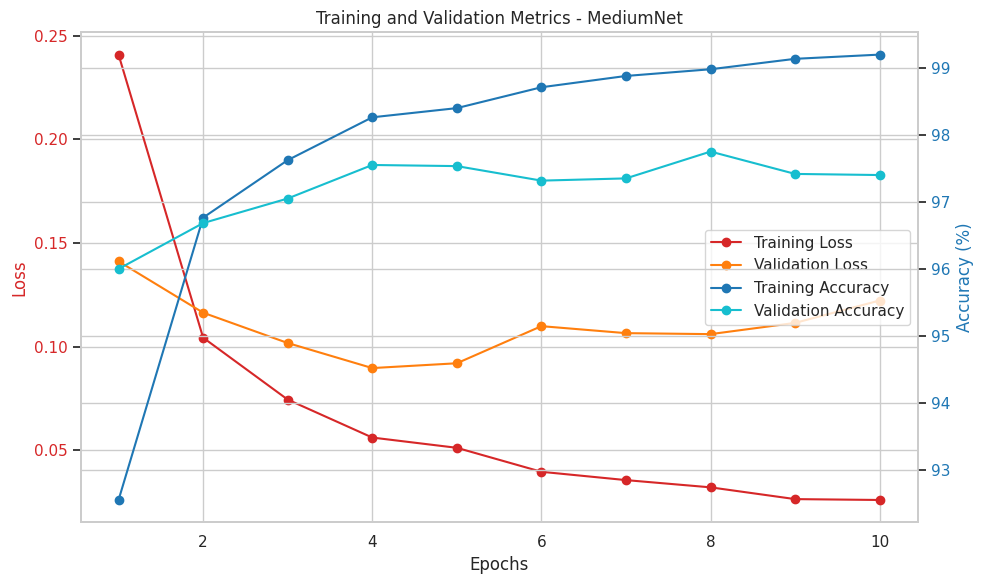

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 97.74%
Applying dynamic quantization to MediumNet...
Quantization completed in 0.01 seconds
Quantized model size: 0.33 MB
Original model size: 1.28 MB
Size reduction: 74.44%
Evaluating quantized model on CPU...
Quantized model test accuracy: 97.69%
Accuracy change: -0.05%
Using device for training: cuda

Training DeepNet...
Number of trainable parameters: 466,698


Training DeepNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 135.70 seconds


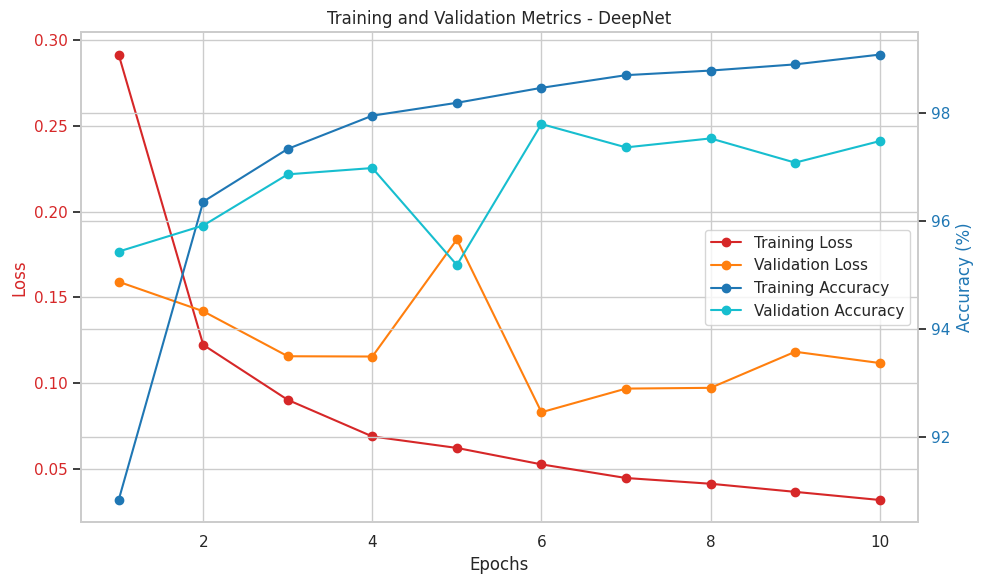

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 97.70%
Applying dynamic quantization to DeepNet...
Quantization completed in 0.01 seconds
Quantized model size: 0.46 MB
Original model size: 1.78 MB
Size reduction: 74.40%
Evaluating quantized model on CPU...
Quantized model test accuracy: 97.66%
Accuracy change: -0.04%
Using device for training: cuda

Training SimpleCNN...
Number of trainable parameters: 31,530


Training SimpleCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 127.40 seconds


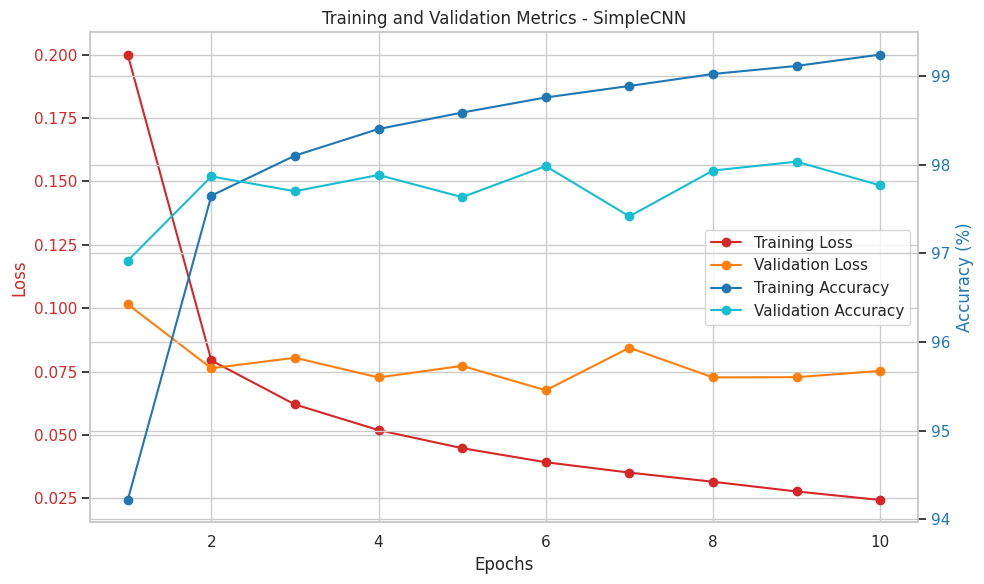

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 98.20%
Applying dynamic quantization to SimpleCNN...
Quantization completed in 0.00 seconds
Quantized model size: 0.03 MB
Original model size: 0.12 MB
Size reduction: 72.70%
Evaluating quantized model on CPU...
Quantized model test accuracy: 98.15%
Accuracy change: -0.05%
Using device for training: cuda

Training MediumCNN...
Number of trainable parameters: 54,666


Training MediumCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 135.46 seconds


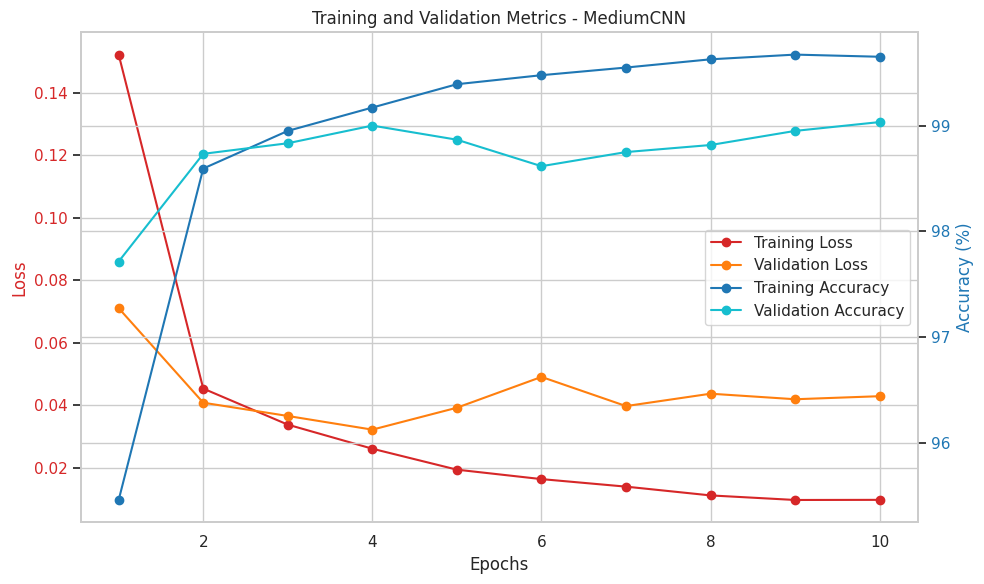

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 99.03%
Applying dynamic quantization to MediumCNN...
Quantization completed in 0.00 seconds
Quantized model size: 0.12 MB
Original model size: 0.21 MB
Size reduction: 41.99%
Evaluating quantized model on CPU...
Quantized model test accuracy: 99.05%
Accuracy change: +0.02%
Using device for training: cuda

Training DeepCNN...
Number of trainable parameters: 938,922


Training DeepCNN:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 156.30 seconds


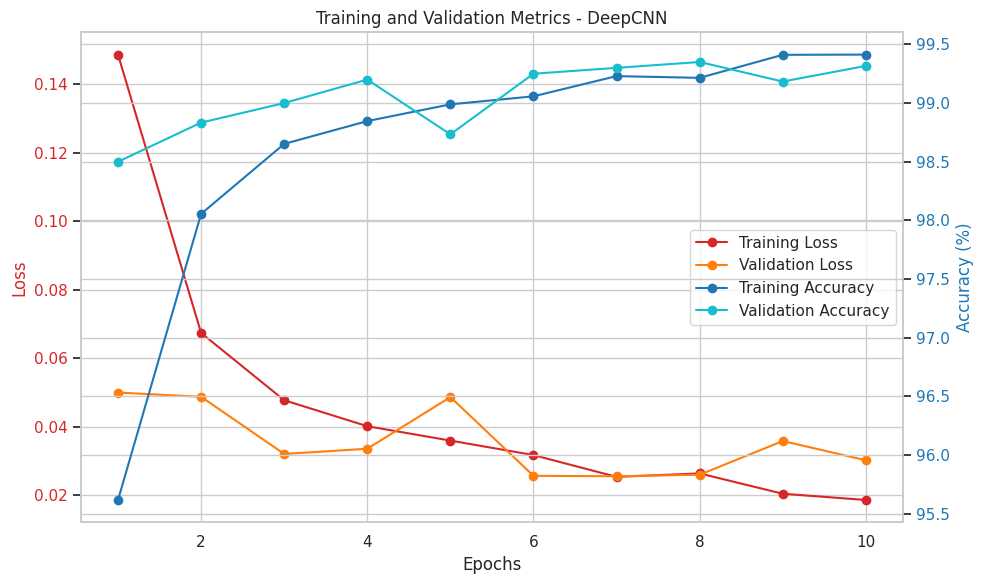

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 99.41%
Applying dynamic quantization to DeepCNN...
Quantization completed in 0.01 seconds
Quantized model size: 1.30 MB
Original model size: 3.59 MB
Size reduction: 63.93%
Evaluating quantized model on CPU...
Quantized model test accuracy: 99.43%
Accuracy change: +0.02%
Using device for training: cuda

Training SimpleResNet...
Number of trainable parameters: 9,690


Training SimpleResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 149.93 seconds


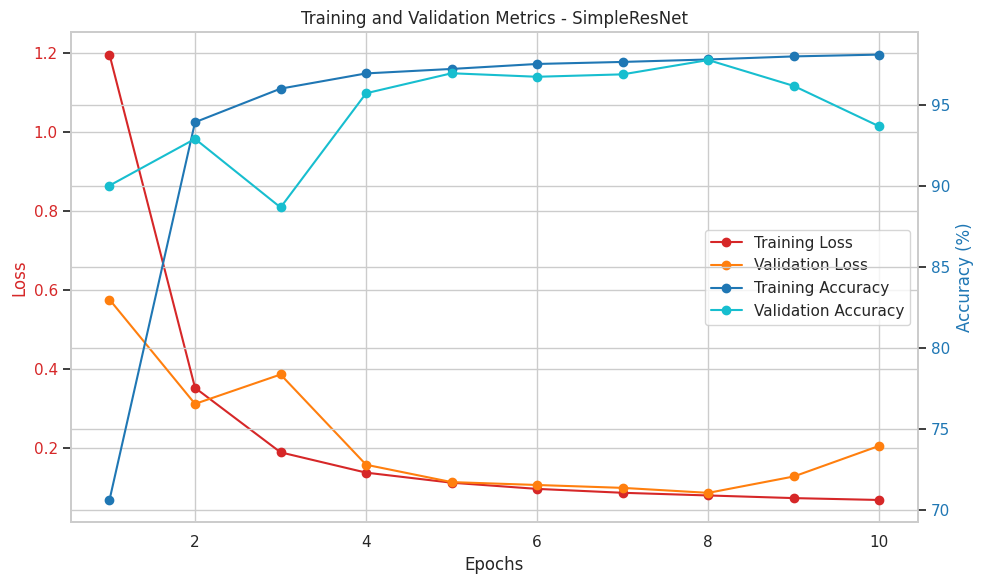

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 94.21%
Applying dynamic quantization to SimpleResNet...
Quantization completed in 0.01 seconds
Quantized model size: 0.05 MB
Original model size: 0.05 MB
Size reduction: -1.41%
Evaluating quantized model on CPU...
Quantized model test accuracy: 94.18%
Accuracy change: -0.03%
Using device for training: cuda

Training MediumResNet...
Number of trainable parameters: 42,938


Training MediumResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 166.63 seconds


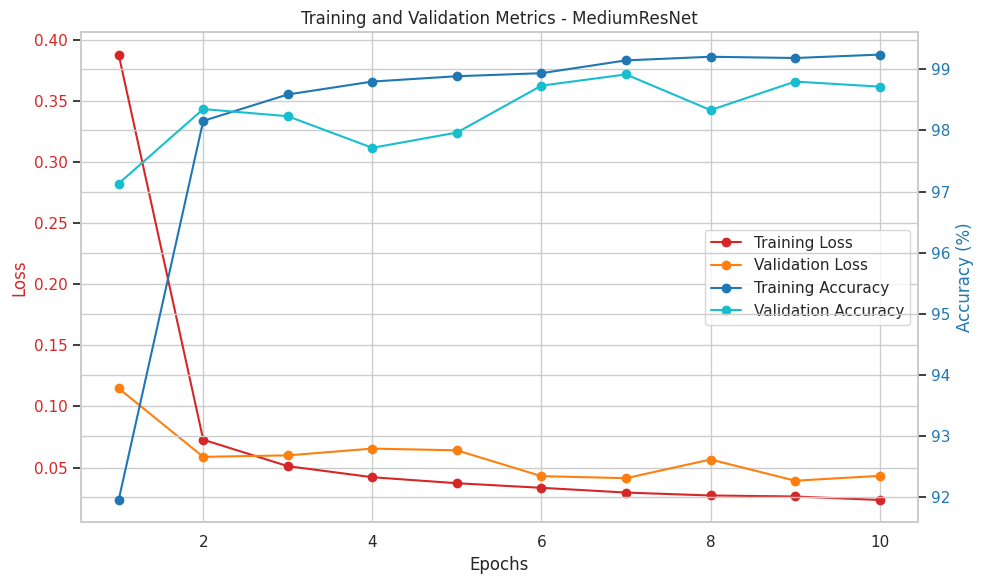

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 98.54%
Applying dynamic quantization to MediumResNet...
Quantization completed in 0.01 seconds
Quantized model size: 0.19 MB
Original model size: 0.18 MB
Size reduction: -0.32%
Evaluating quantized model on CPU...
Quantized model test accuracy: 98.54%
Accuracy change: +0.00%
Using device for training: cuda

Training DeepResNet...
Number of trainable parameters: 267,514


Training DeepResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Training completed in 203.72 seconds


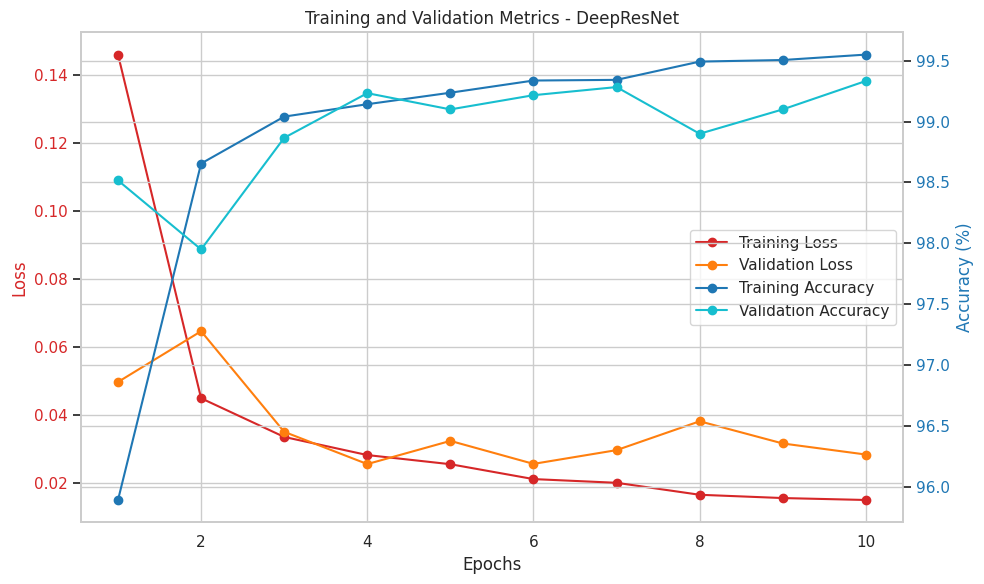

Evaluating original model on CPU before quantization...
Original model test accuracy (CPU): 99.25%
Applying dynamic quantization to DeepResNet...
Quantization completed in 0.01 seconds
Quantized model size: 1.06 MB
Original model size: 1.06 MB
Size reduction: -0.01%
Evaluating quantized model on CPU...
Quantized model test accuracy: 99.25%
Accuracy change: +0.00%


In [19]:
def train_and_evaluate_quantized_model(model_class, model_name, hidden_size=128, epochs=10,
                                      learning_rate=0.001, export_dir='./models'):
    """
    Train or load, then dynamically quantize, evaluate, and store model information.

    Args:
        model_class: PyTorch model class
        model_name: Name for the model
        hidden_size: Size of hidden layers
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        export_dir: Directory to save exported models

    Returns:
        dict: Dictionary with model information and results
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device for training: {device}")

    # Initialize model
    model = model_class(hidden_size=hidden_size).to(device)
    print(f"\nPreparing {model_name} for quantization...")

    # Count parameters
    param_count = count_parameters(model)
    print(f"Number of trainable parameters: {param_count:,}")

    # Check if model already exists and load it
    model_path = os.path.join(export_dir, f"{model_name}.pt")
    if os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        model.load_state_dict(torch.load(model_path))
    else:
        print(f"Pre-trained model not found. Training {model_name} from scratch...")

        # Set up loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # For storing metrics
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        # Create a single progress bar for the entire training process
        pbar = tqdm(total=epochs, desc=f"Training {model_name}")

        # Training loop
        start_time = time.time()
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training phase
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate epoch metrics for training
            epoch_train_loss = running_loss / len(train_loader)
            epoch_train_acc = 100 * correct / total
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Calculate epoch metrics for validation
            epoch_val_loss = val_loss / len(val_loader)
            epoch_val_acc = 100 * correct / total
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            # Update progress bar with current metrics
            pbar.update(1)
            pbar.set_postfix({
                'epoch': f"{epoch+1}/{epochs}",
                'train_loss': f"{epoch_train_loss:.4f}",
                'train_acc': f"{epoch_train_acc:.2f}%",
                'val_loss': f"{epoch_val_loss:.4f}",
                'val_acc': f"{epoch_val_acc:.2f}%"
            })

        # Close progress bar
        pbar.close()

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Plot training and validation metrics if we trained
        plot_training_metrics(train_losses, val_losses, train_accs, val_accs, model_name)

        # Save the trained model
        os.makedirs(export_dir, exist_ok=True)
        torch.save(model.state_dict(), model_path)
        print(f"Saved trained model to {model_path}")

    # Get non-quantized model accuracy on CPU for fair comparison
    print("Evaluating original model on CPU before quantization...")
    model = model.cpu()
    orig_test_acc = calculate_accuracy(model, test_loader, torch.device('cpu'))
    print(f"Original model test accuracy (CPU): {orig_test_acc:.2f}%")

    # Dynamic Quantization - must be on CPU
    print(f"Applying dynamic quantization to {model_name}...")
    quantization_start_time = time.time()

    # Apply dynamic quantization - only supported on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model,  # the original model (already on CPU)
        {nn.Linear, nn.Conv2d},  # a set of layers to dynamically quantize
        dtype=torch.qint8  # the target dtype for quantized weights
    )

    quantization_time = time.time() - quantization_start_time
    print(f"Quantization completed in {quantization_time:.2f} seconds")

    # Export model and calculate size
    os.makedirs(export_dir, exist_ok=True)
    quantized_model_path = os.path.join(export_dir, f"{model_name}_quantized.pt")

    # Save the quantized model
    torch.save(quantized_model.state_dict(), quantized_model_path)

    # Get quantized model file size
    model_size_bytes = os.path.getsize(quantized_model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Quantized model size: {model_size_mb:.2f} MB")

    # Get original model file size for comparison
    orig_model_path = os.path.join(export_dir, f"{model_name}.pt")
    orig_size_bytes = os.path.getsize(orig_model_path)
    orig_size_mb = orig_size_bytes / (1024 * 1024)
    print(f"Original model size: {orig_size_mb:.2f} MB")
    print(f"Size reduction: {(1 - model_size_mb/orig_size_mb) * 100:.2f}%")

    # Evaluate quantized model on test set (on CPU)
    print("Evaluating quantized model on CPU...")
    test_acc = calculate_accuracy(quantized_model, test_loader, torch.device('cpu'))
    print(f"Quantized model test accuracy: {test_acc:.2f}%")
    print(f"Accuracy change: {test_acc - orig_test_acc:+.2f}%")

    # Store results
    results = {
        'model_name': f"{model_name}_quantized",
        'parameters': param_count,
        'quantization_time': quantization_time,
        'orig_model_size_mb': orig_size_mb,
        'model_size_mb': model_size_mb,
        'size_reduction_pct': (1 - model_size_mb/orig_size_mb) * 100,
        'orig_test_acc': orig_test_acc,
        'test_acc': test_acc,
        'accuracy_change': test_acc - orig_test_acc,
        'hidden_size': hidden_size
    }

    # Add to global dictionary
    model_results[f"{model_name}_quantized"] = results

    # Save results to pickle file
    with open('model_results.pkl', 'wb') as f:
        pickle.dump(model_results, f)

    return results

# MLP models
_ = train_and_evaluate_quantized_model(SimpleNet, "SimpleNet", hidden_size=256)
_ = train_and_evaluate_quantized_model(MediumNet, "MediumNet", hidden_size=256)
_ = train_and_evaluate_quantized_model(DeepNet, "DeepNet", hidden_size=256)

# CNN models
_ = train_and_evaluate_quantized_model(SimpleCNN, "SimpleCNN", hidden_size=16)
_ = train_and_evaluate_quantized_model(MediumCNN, "MediumCNN", hidden_size=16)
_ = train_and_evaluate_quantized_model(DeepCNN, "DeepCNN", hidden_size=16)

# ResNet models
_ = train_and_evaluate_quantized_model(SimpleResNet, "SimpleResNet", hidden_size=16)
_ = train_and_evaluate_quantized_model(MediumResNet, "MediumResNet", hidden_size=16)
_ = train_and_evaluate_quantized_model(DeepResNet, "DeepResNet", hidden_size=16)

In [22]:
def train_and_evaluate_pruned_model(model_class, model_name, hidden_size=128, epochs=10,
                                   learning_rate=0.001, export_dir='./models',
                                   prune_amount=0.5, prune_iterations=5):
    """
    Train or load, then prune, fine-tune, evaluate, and store model information.

    Args:
        model_class: PyTorch model class
        model_name: Name for the model
        hidden_size: Size of hidden layers
        epochs: Number of training epochs (before pruning)
        learning_rate: Learning rate for optimizer
        export_dir: Directory to save exported models
        prune_amount: Amount of parameters to prune (0.0 to 1.0)
        prune_iterations: Number of pruning iterations

    Returns:
        dict: Dictionary with model information and results
    """
    import torch.nn.utils.prune as prune

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = model_class(hidden_size=hidden_size).to(device)
    print(f"\nPreparing {model_name} for pruning...")

    # Count parameters
    initial_param_count = count_parameters(model)
    print(f"Initial number of trainable parameters: {initial_param_count:,}")

    # Check if model already exists and load it
    model_path = os.path.join(export_dir, f"{model_name}.pt")
    if os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        model.load_state_dict(torch.load(model_path))
    else:
        print(f"Pre-trained model not found. Training {model_name} from scratch...")

        # Set up loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # For storing metrics
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []

        # Create a single progress bar for the entire training process
        pbar = tqdm(total=epochs, desc=f"Training {model_name} (pre-pruning)")

        # Training loop
        start_time = time.time()
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training phase
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate epoch metrics for training
            epoch_train_loss = running_loss / len(train_loader)
            epoch_train_acc = 100 * correct / total
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Calculate epoch metrics for validation
            epoch_val_loss = val_loss / len(val_loader)
            epoch_val_acc = 100 * correct / total
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            # Update progress bar with current metrics
            pbar.update(1)
            pbar.set_postfix({
                'epoch': f"{epoch+1}/{epochs}",
                'train_loss': f"{epoch_train_loss:.4f}",
                'train_acc': f"{epoch_train_acc:.2f}%",
                'val_loss': f"{epoch_val_loss:.4f}",
                'val_acc': f"{epoch_val_acc:.2f}%"
            })

        # Close progress bar
        pbar.close()

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Plot training and validation metrics
        plot_training_metrics(train_losses, val_losses, train_accs, val_accs, model_name)

        # Save the trained model
        os.makedirs(export_dir, exist_ok=True)
        torch.save(model.state_dict(), model_path)
        print(f"Saved trained model to {model_path}")

    # Save the original model for size comparison
    orig_model_path = os.path.join(export_dir, f"{model_name}.pt")
    orig_size_bytes = os.path.getsize(orig_model_path)
    orig_size_mb = orig_size_bytes / (1024 * 1024)
    print(f"Original model size: {orig_size_mb:.2f} MB")

    # Evaluate initial model on test set for baseline
    initial_test_acc = calculate_accuracy(model, test_loader, device)
    print(f"Initial model test accuracy: {initial_test_acc:.2f}%")

    # ----- Pruning phase -----
    print(f"Applying iterative pruning to {model_name}...")
    pruning_start_time = time.time()

    # Get all prunable layers (Conv2d and Linear)
    prunable_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prunable_layers.append((name, module))

    # Create a single progress bar for all pruning iterations
    prune_pbar = tqdm(total=prune_iterations, desc=f"Pruning {model_name}")

    # Set up optimizer for fine-tuning
    optimizer = optim.Adam(model.parameters(), lr=learning_rate/10)  # Lower learning rate for fine-tuning
    criterion = nn.CrossEntropyLoss()

    # Iterative pruning with fine-tuning
    for i in range(prune_iterations):
        # Apply pruning to each prunable layer
        for name, module in prunable_layers:
            if hasattr(module, 'weight'):
                # For layers that were already pruned, we need a different approach
                if hasattr(module, 'weight_orig'):
                    prune.l1_unstructured(module, name='weight', amount=prune_amount)
                else:
                    prune.l1_unstructured(module, name='weight', amount=prune_amount)

        # Fine-tune for a single epoch after pruning
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics for progress bar update
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update the progress bar
        prune_pbar.update(1)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # Count current non-zero parameters for progress tracking
        current_nonzero = 0
        current_total = 0
        for name, param in model.named_parameters():
            if 'weight' in name:
                tensor = param.data.cpu().numpy()
                current_nonzero += np.count_nonzero(tensor)
                current_total += tensor.size

        current_sparsity = 1.0 - (current_nonzero / current_total)

        prune_pbar.set_postfix({
            'iteration': f"{i+1}/{prune_iterations}",
            'fine_tune_loss': f"{epoch_train_loss:.4f}",
            'fine_tune_acc': f"{epoch_train_acc:.2f}%",
            'sparsity': f"{current_sparsity:.2%}"
        })

    # Close pruning progress bar
    prune_pbar.close()

    pruning_time = time.time() - pruning_start_time
    print(f"Pruning completed in {pruning_time:.2f} seconds")

    # Make pruning permanent
    for name, module in prunable_layers:
        if hasattr(module, 'weight_orig'):
            prune.remove(module, 'weight')

    # Count remaining non-zero parameters
    nonzero_params = 0
    total_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name or 'bias' in name:
            tensor = param.data.cpu().numpy()
            nz_count = np.count_nonzero(tensor)
            total_count = tensor.size
            nonzero_params += nz_count
            total_params += total_count

    sparsity = 1.0 - (nonzero_params / total_params)
    print(f"Model sparsity after pruning: {sparsity:.2%}")
    print(f"Remaining non-zero parameters: {nonzero_params:,} / {total_params:,}")

    # Export model and calculate size
    pruned_model_path = os.path.join(export_dir, f"{model_name}_pruned.pt")

    # Save the pruned model
    torch.save(model.state_dict(), pruned_model_path)

    # Get pruned model file size
    model_size_bytes = os.path.getsize(pruned_model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Pruned model size: {model_size_mb:.2f} MB")
    print(f"Size reduction: {(1 - model_size_mb/orig_size_mb) * 100:.2f}%")

    # Evaluate pruned model on test set
    test_acc = calculate_accuracy(model, test_loader, device)
    print(f"Pruned model test accuracy: {test_acc:.2f}%")
    print(f"Accuracy change: {test_acc - initial_test_acc:+.2f}%")

    # Store results
    results = {
        'model_name': f"{model_name}_pruned",
        'initial_parameters': initial_param_count,
        'nonzero_parameters': nonzero_params,
        'total_parameters': total_params,
        'sparsity': sparsity,
        'pruning_time': pruning_time,
        'orig_model_size_mb': orig_size_mb,
        'model_size_mb': model_size_mb,
        'size_reduction_pct': (1 - model_size_mb/orig_size_mb) * 100,
        'initial_test_acc': initial_test_acc,
        'final_test_acc': test_acc,
        'accuracy_change': test_acc - initial_test_acc,
        'hidden_size': hidden_size,
        'prune_amount': prune_amount,
        'prune_iterations': prune_iterations
    }

    # Add to global dictionary
    model_results[f"{model_name}_pruned"] = results

    # Save results to pickle file
    with open('model_results.pkl', 'wb') as f:
        pickle.dump(model_results, f)

    return results

# MLP models
_ = train_and_evaluate_pruned_model(SimpleNet, "SimpleNet", hidden_size=256)
_ = train_and_evaluate_pruned_model(MediumNet, "MediumNet", hidden_size=256)
_ = train_and_evaluate_pruned_model(DeepNet, "DeepNet", hidden_size=256)

# CNN models
_ = train_and_evaluate_pruned_model(SimpleCNN, "SimpleCNN", hidden_size=16)
_ = train_and_evaluate_pruned_model(MediumCNN, "MediumCNN", hidden_size=16)
_ = train_and_evaluate_pruned_model(DeepCNN, "DeepCNN", hidden_size=16)

# ResNet models
_ = train_and_evaluate_pruned_model(SimpleResNet, "SimpleResNet", hidden_size=16)
_ = train_and_evaluate_pruned_model(MediumResNet, "MediumResNet", hidden_size=16)
_ = train_and_evaluate_pruned_model(DeepResNet, "DeepResNet", hidden_size=16)

Using device: cuda

Training SimpleNet for pruning...
Initial number of trainable parameters: 203,530


Training SimpleNet (pre-pruning):   0%|          | 0/10 [00:00<?, ?it/s]

Initial training completed in 128.05 seconds
Original model size: 0.78 MB
Initial model test accuracy: 97.98%
Applying iterative pruning to SimpleNet...


Pruning SimpleNet:   0%|          | 0/5 [00:00<?, ?it/s]

Pruning completed in 58.30 seconds
Model sparsity after pruning: 96.75%
Remaining non-zero parameters: 6,618 / 203,530
Pruned model size: 0.78 MB
Size reduction: -0.01%
Pruned model test accuracy: 94.15%
Accuracy change: -3.83%
Using device: cuda

Training MediumNet for pruning...
Initial number of trainable parameters: 335,114


Training MediumNet (pre-pruning):   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Using device: cuda

Preparing SimpleNet as student...
Student parameters: 203,530
Teacher (MediumNet) parameters: 335,114
Loaded pre-trained teacher model from ./models/MediumNet.pt
Loaded standard student model from ./models/SimpleNet.pt for comparison
Model compression ratio: 1.65x (teacher/student)
Teacher model size: 1.28 MB
Standard student model size: 0.78 MB
Size reduction: 39.25%
Teacher model test accuracy: 97.74%
Standard student test accuracy: 97.98%
Accuracy gap (teacher - standard): -0.24%


Distilling SimpleNet from MediumNet:   0%|          | 0/10 [00:00<?, ?it/s]

Distillation completed in 132.87 seconds


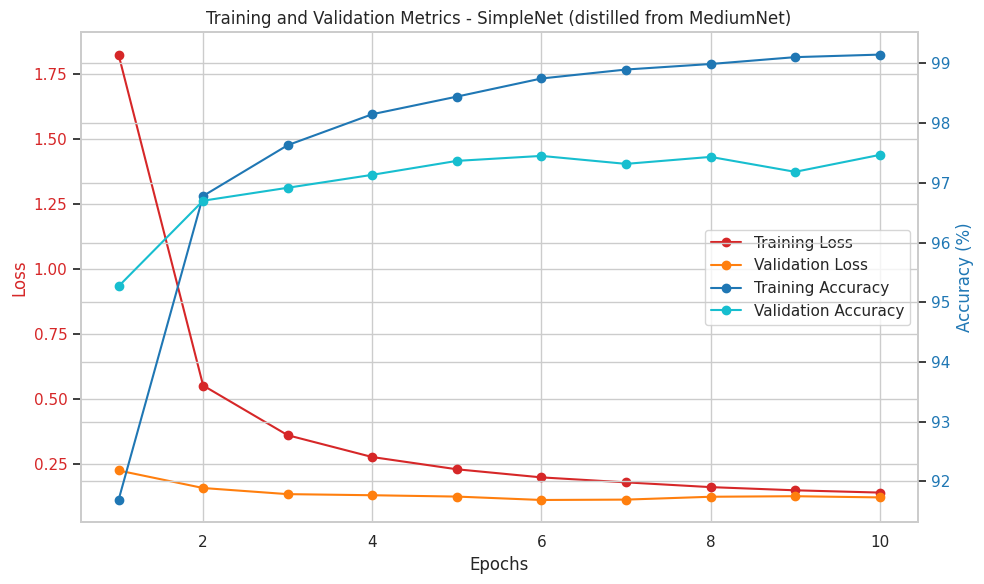

Distilled model size: 0.78 MB
Distilled model test accuracy: 97.51%
Compared to teacher: -0.23%
Compared to standard student: -0.47%
Size comparison to teacher: 39.22% smaller
Using device: cuda

Preparing SimpleNet as student...
Student parameters: 203,530
Teacher (DeepNet) parameters: 466,698
Loaded pre-trained teacher model from ./models/DeepNet.pt
Loaded standard student model from ./models/SimpleNet.pt for comparison
Model compression ratio: 2.29x (teacher/student)
Teacher model size: 1.78 MB
Standard student model size: 0.78 MB
Size reduction: 56.37%
Teacher model test accuracy: 97.70%
Standard student test accuracy: 97.98%
Accuracy gap (teacher - standard): -0.28%


Distilling SimpleNet from DeepNet:   0%|          | 0/10 [00:00<?, ?it/s]

Distillation completed in 150.00 seconds


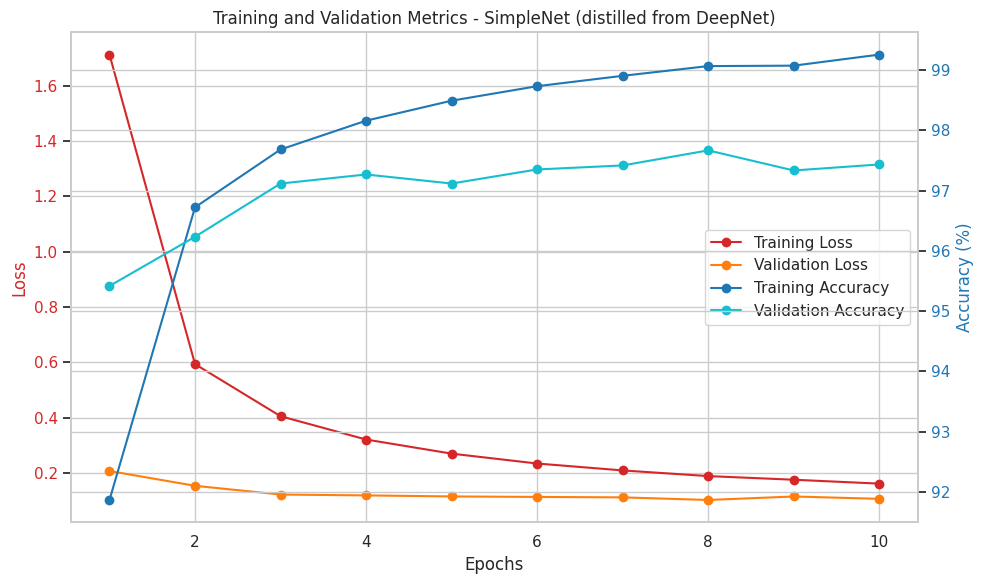

Distilled model size: 0.78 MB


KeyboardInterrupt: 

In [23]:
def train_and_evaluate_distilled_model(student_class, teacher_class, model_name, teacher_name,
                                      student_hidden_size=128, teacher_hidden_size=128,
                                      epochs=10, learning_rate=0.001, export_dir='./models',
                                      alpha=0.5, temperature=4.0):
    """
    Train a student model with knowledge distillation from a teacher model.

    Args:
        student_class: PyTorch model class for the student
        teacher_class: PyTorch model class for the teacher
        model_name: Name for the student model
        teacher_name: Name for the teacher model
        student_hidden_size: Size of hidden layers for student
        teacher_hidden_size: Size of hidden layers for teacher
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        export_dir: Directory to save exported models
        alpha: Weight for distillation loss (0.0 to 1.0)
        temperature: Temperature for softening probabilities

    Returns:
        dict: Dictionary with model information and results
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize student model
    student = student_class(hidden_size=student_hidden_size).to(device)
    print(f"\nPreparing {model_name} as student...")

    # Count parameters
    student_param_count = count_parameters(student)
    print(f"Student parameters: {student_param_count:,}")

    # Initialize and load teacher model
    teacher = teacher_class(hidden_size=teacher_hidden_size).to(device)
    teacher_param_count = count_parameters(teacher)
    print(f"Teacher ({teacher_name}) parameters: {teacher_param_count:,}")

    # Check if teacher model exists and load it
    teacher_path = os.path.join(export_dir, f"{teacher_name}.pt")
    if os.path.exists(teacher_path):
        teacher.load_state_dict(torch.load(teacher_path))
        print(f"Loaded pre-trained teacher model from {teacher_path}")
    else:
        print(f"Pre-trained teacher model not found at {teacher_path}")
        print("Training teacher model first...")

        # Train teacher if not available
        train_and_evaluate_model(teacher_class, teacher_name,
                              hidden_size=teacher_hidden_size,
                              epochs=epochs,
                              learning_rate=learning_rate,
                              export_dir=export_dir)

        # Load the trained teacher
        teacher.load_state_dict(torch.load(teacher_path))
        print(f"Loaded newly trained teacher model from {teacher_path}")

    # Set teacher to evaluation mode
    teacher.eval()

    # Check if standard student model exists and load it for comparison
    standard_path = os.path.join(export_dir, f"{model_name}.pt")
    standard_student = student_class(hidden_size=student_hidden_size).to(device)

    if os.path.exists(standard_path):
        standard_student.load_state_dict(torch.load(standard_path))
        print(f"Loaded standard student model from {standard_path} for comparison")
    else:
        print(f"Standard student model not found at {standard_path}")
        print("Training standard student model first...")

        # Train standard student if not available
        train_and_evaluate_model(student_class, model_name,
                              hidden_size=student_hidden_size,
                              epochs=epochs,
                              learning_rate=learning_rate,
                              export_dir=export_dir)

        # Load the trained standard student
        standard_student.load_state_dict(torch.load(standard_path))
        print(f"Loaded newly trained standard student model from {standard_path}")

    # Get file sizes for comparison
    teacher_size_bytes = os.path.getsize(teacher_path)
    teacher_size_mb = teacher_size_bytes / (1024 * 1024)

    standard_size_bytes = os.path.getsize(standard_path)
    standard_size_mb = standard_size_bytes / (1024 * 1024)

    # Calculate compression ratio
    compression_ratio = teacher_param_count / student_param_count
    print(f"Model compression ratio: {compression_ratio:.2f}x (teacher/student)")
    print(f"Teacher model size: {teacher_size_mb:.2f} MB")
    print(f"Standard student model size: {standard_size_mb:.2f} MB")
    print(f"Size reduction: {(1 - standard_size_mb/teacher_size_mb) * 100:.2f}%")

    # Evaluate teacher and standard student models for baseline
    teacher_acc = calculate_accuracy(teacher, test_loader, device)
    print(f"Teacher model test accuracy: {teacher_acc:.2f}%")

    standard_acc = calculate_accuracy(standard_student, test_loader, device)
    print(f"Standard student test accuracy: {standard_acc:.2f}%")
    print(f"Accuracy gap (teacher - standard): {teacher_acc - standard_acc:+.2f}%")

    # Set up loss functions and optimizer
    criterion = nn.CrossEntropyLoss()
    kl_div_loss = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    # For storing metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Create a single progress bar for the entire training process
    pbar = tqdm(total=epochs, desc=f"Distilling {model_name} from {teacher_name}")

    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass for student
            student_logits = student(inputs)

            # Forward pass for teacher (no grad)
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Calculate soft targets from teacher
            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=1)

            # Calculate log probabilities from student with temperature
            log_probs = nn.functional.log_softmax(student_logits / temperature, dim=1)

            # Hard loss: student predictions vs true labels
            hard_loss = criterion(student_logits, labels)

            # Soft loss: KL divergence between student and teacher distributions
            soft_loss = kl_div_loss(log_probs, soft_targets) * (temperature**2)

            # Combined loss with alpha weight
            loss = alpha * soft_loss + (1 - alpha) * hard_loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(student_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch metrics for training
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        student.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                loss = criterion(outputs, labels)  # Only using hard loss for validation

                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate epoch metrics for validation
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update progress bar with current metrics
        pbar.update(1)
        pbar.set_postfix({
            'epoch': f"{epoch+1}/{epochs}",
            'train_loss': f"{epoch_train_loss:.4f}",
            'train_acc': f"{epoch_train_acc:.2f}%",
            'val_loss': f"{epoch_val_loss:.4f}",
            'val_acc': f"{epoch_val_acc:.2f}%"
        })

    # Close progress bar
    pbar.close()

    distillation_time = time.time() - start_time
    print(f"Distillation completed in {distillation_time:.2f} seconds")

    # Plot training and validation metrics
    plot_training_metrics(train_losses, val_losses, train_accs, val_accs,
                         f"{model_name} (distilled from {teacher_name})")

    # Export model and calculate size
    os.makedirs(export_dir, exist_ok=True)
    distilled_model_path = os.path.join(export_dir, f"{model_name}_distilled_from_{teacher_name}.pt")

    # Save the distilled model
    torch.save(student.state_dict(), distilled_model_path)

    # Get distilled model file size
    model_size_bytes = os.path.getsize(distilled_model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Distilled model size: {model_size_mb:.2f} MB")

    # Evaluate distilled model on test set
    student_acc = calculate_accuracy(student, test_loader, device)
    print(f"Distilled model test accuracy: {student_acc:.2f}%")

    # Calculate and display deltas
    print(f"Compared to teacher: {student_acc - teacher_acc:+.2f}%")
    print(f"Compared to standard student: {student_acc - standard_acc:+.2f}%")
    print(f"Size comparison to teacher: {(1 - model_size_mb/teacher_size_mb) * 100:.2f}% smaller")

    # Store results
    results = {
        'model_name': f"{model_name}_distilled_from_{teacher_name}",
        'teacher_name': teacher_name,
        'student_parameters': student_param_count,
        'teacher_parameters': teacher_param_count,
        'compression_ratio': compression_ratio,
        'distillation_time': distillation_time,
        'teacher_size_mb': teacher_size_mb,
        'standard_size_mb': standard_size_mb,
        'distilled_size_mb': model_size_mb,
        'size_reduction_pct': (1 - model_size_mb/teacher_size_mb) * 100,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'teacher_test_acc': teacher_acc,
        'standard_test_acc': standard_acc,
        'student_test_acc': student_acc,
        'accuracy_vs_teacher': student_acc - teacher_acc,
        'accuracy_vs_standard': student_acc - standard_acc,
        'student_hidden_size': student_hidden_size,
        'teacher_hidden_size': teacher_hidden_size,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'alpha': alpha,
        'temperature': temperature
    }

    # Add to global dictionary
    model_results[f"{model_name}_distilled_from_{teacher_name}"] = results

    # Save results to pickle file
    with open('model_results.pkl', 'wb') as f:
        pickle.dump(model_results, f)

    return results

_ = train_and_evaluate_distilled_model(SimpleNet, MediumNet, "SimpleNet", "MediumNet", 256, 256)
_ = train_and_evaluate_distilled_model(SimpleNet, DeepNet, "SimpleNet", "DeepNet", 256, 256)
_ = train_and_evaluate_distilled_model(MediumNet, DeepNet, "MediumNet", "DeepNet", 256, 256)

_ = train_and_evaluate_distilled_model(SimpleCNN, MediumCNN, "SimpleCNN", "MediumCNN", 16, 16)
_ = train_and_evaluate_distilled_model(SimpleCNN, DeepCNN, "SimpleCNN", "DeepCNN", 16, 16)
_ = train_and_evaluate_distilled_model(MediumCNN, DeepCNN, "MediumCNN", "DeepCNN", 16, 16)

_ = train_and_evaluate_distilled_model(SimpleResNet, MediumResNet, "SimpleResNet", "MediumResNet", 16, 16)
_ = train_and_evaluate_distilled_model(SimpleResNet, DeepResNet, "SimpleResNet", "DeepResNet", 16, 16)
_ = train_and_evaluate_distilled_model(MediumResNet, DeepResNet, "MediumResNet", "DeepResNet", 16, 16)

Using device: cuda

Preparing SimpleResNet as student...
Student parameters: 9,690
Teacher (DeepResNet) parameters: 267,514
Loaded pre-trained teacher model from ./models/DeepResNet.pt
Loaded standard student model from ./models/SimpleResNet.pt for comparison
Model compression ratio: 27.61x (teacher/student)
Teacher model size: 1.06 MB
Standard student model size: 0.05 MB
Size reduction: 95.52%
Teacher model test accuracy: 99.25%
Standard student test accuracy: 94.21%
Accuracy gap (teacher - standard): +5.04%


Distilling SimpleResNet from DeepResNet:   0%|          | 0/10 [00:00<?, ?it/s]

Distillation completed in 184.51 seconds


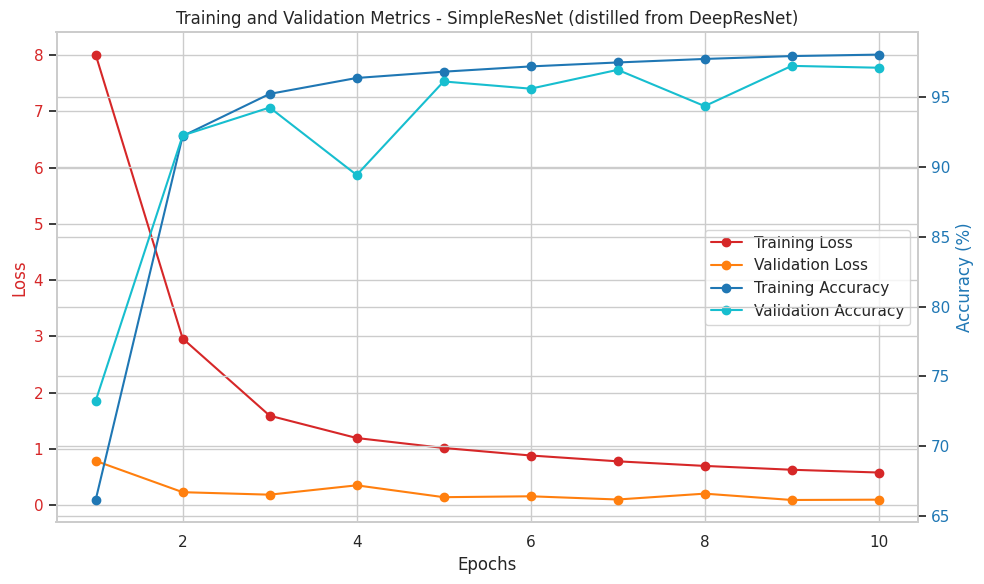

Distilled model size: 0.05 MB
Distilled model test accuracy: 97.08%
Compared to teacher: -2.17%
Compared to standard student: +2.87%
Size comparison to teacher: 95.39% smaller


In [24]:
_ = train_and_evaluate_distilled_model(SimpleResNet, DeepResNet, "SimpleResNet", "DeepResNet", 16, 16)